#Comenzamos el proyecto ahora en un .ipynb, para que quede todo un poco más clarito. 


La estructura es:
-Descargamos unos datos de 3 fuentes distintas. Les damos formato, con dataclass. Se grafican para su analisis, se hace la matriz de varianzas y covariazas, se recomienda una cartera con pesos eficientes para esos valores. 

-En otra celda, intentaré descargar información relevante de la empresa y generar un archivo 

In [90]:
# Esta celda carga todas las "herramientas" que vamos a necesitar.
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta, date
from dotenv import load_dotenv  # Para cargar nuestras claves API secretas
import json
import yfinance as yf
from twelvedata import TDClient
from dataclasses import dataclass, asdict # 'dataclass' es nuestro "molde", 'asdict' para convertirlo a DataFrame
import missingno as mso
import matplotlib.pyplot as plt
from numpy.random import default_rng

print("✅ Librerías importadas con éxito.")

✅ Librerías importadas con éxito.


Creamos la @DataClass para estandarizar la estructura de los datos


In [91]:

@dataclass
class StockData: 
    symbol: str
    date: date # 'date' (solo fecha), no 'datetime' (fecha y hora), voy a trabajar con datos gratuitos EOD
    open: float 
    high: float 
    low: float
    close: float 
    volume: float 
    fuente_datos: str = "" # plataforma de los datos

print(f"Definido el 'molde' StockData: {StockData(symbol='EJEMPLO', date=date.today(), open=100.0, high=101.0, low=99.0, close=100.5, volume=1000, fuente_datos='Test')}")

Definido el 'molde' StockData: StockData(symbol='EJEMPLO', date=datetime.date(2025, 10, 29), open=100.0, high=101.0, low=99.0, close=100.5, volume=1000, fuente_datos='Test')


Cargamos las API de las fuentes, en este caso, 12data, Alpha vantage y finnhub

In [92]:
# Define la ruta COMPLETA a tu archivo .env
ruta_del_proyecto = "/Users/emiliosanchez/Desktop/MIAX/proyecto1_descarga_datos/proyecto1"
ruta_env = os.path.join(ruta_del_proyecto, ".env")

# Carga el .env desde esa ruta específica
load_dotenv(dotenv_path=ruta_env)
ALPHA_KEY = os.getenv("alpha_key")
TWELVE_DATA_KEY = os.getenv("12data_key")

if not ALPHA_KEY or not TWELVE_DATA_KEY:
    # Si no encuentra las claves, detiene la ejecución con un error claro
    raise SystemExit("❌ ERROR: No se encontraron las API keys en el .env. Revisar archivo.")
else:
    print("✅ API Keys cargadas correctamente.")

✅ API Keys cargadas correctamente.


Definimos los parámetros de la descarga. Los valores, y el rango de fechas.


In [93]:
TICKERS = ["GOOG", "AAPL"] # ¡¡¡ aquí en un futuro cercano quiero que me lo pida por pantalla
end_date = datetime.today()
start_date = end_date - timedelta(days=1000) # lo msmo  ¡¡¡ aquí en un futuro cercano quiero que me lo pida por pantalla

# Convertimos las fechas a texto (string) en formato YYYY-MM-DD
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Tickers a buscar: {TICKERS}")
print(f"Rango de fechas: {start_date_str} a {end_date_str}")

Tickers a buscar: ['GOOG', 'AAPL']
Rango de fechas: 2023-02-02 a 2025-10-29


Ahora lo importante:
Definimos las 3 funciones de descarga de datos descarga de datos EOD

In [94]:
# --- 2.1 DE YAHOO FINANCE ---
def descargar_yfinance(symbol):
    """Descarga y limpia datos diarios de Yahoo Finance."""
    print(f"  -> Obteniendo datos de Yahoo Finance para {symbol}...")
    try:
        # auto_adjust=True ajusta los precios a splits/dividendos (obtiene Adj Close)
        df = yf.download(symbol, start=start_date_str, end=end_date_str, auto_adjust=True) # <-- CAMBIO AQUÍ
        
        if df.empty:
            print(f"  ⚠️  {symbol} (Yahoo Finance): No se encontraron datos.")
            return None
        # Aplanar MultiIndex, si no da problemas al hacer el pd.concatisinstance() 
        # es una función que comprueba si las columnas de tu tabla de datos (df.columns) son de tipo MultiIndex.
        # Si la respuesta es sí, la siguiente línea se ejecuta eliminando la columna
        #lo de preguntar es una mera formalidad vaya, porque en Yahoo es que sí
   
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)

        
        # 1. Resetear el índice PRIMERO para que 'Date' se convierta en una columna
        df = df.reset_index()
        
        # 2. AHORA, convertir todos los nombres de columnas a minúsculas.
        df.columns = df.columns.str.lower()
        
        # El bloque 'adj close' se elimina, ya que auto_adjust=True pone el valor ajustado directamente en 'close'

        # Añadir columnas de metadatos
        df['symbol'] = symbol 
            
        print(f"  ✅ {symbol} (Yahoo Finance): {len(df)} filas descargadas (Adj Close).")
        print(df.head())
        return df
    except Exception as e:
        print(f"   ❌ {symbol} (Yahoo Finance): Ocurrió un error - {e}")
        return None

# --- 2.2 DESCARGA DE ALPHA VANTAGE ---
def descargar_alpha_vantage(symbol):
    """Descarga datos diarios de Alpha Vantage."""
    print(f"  -> Obteniendo datos de Alpha Vantage para {symbol}...")
    try:
        request= requests.get(f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=compact&apikey={ALPHA_KEY}", timeout=(5, 45))
        request.raise_for_status() # Si hay un error (ej. 404, 500), se detiene aquí
        data = request.json()
        
        # El JSON de Alpha Vantage tiene una clave principal que cambia (ej. "Time Series (Daily)")
        # Este bucle la encuentra 
        key = None
        for k in data:
            if "Time Series" in k:
                key = k
                break 

        if not key: 
            print(f"  ⚠️  {symbol} (Alpha Vantage): No se encontró 'Time Series'. Respuesta: {data}")
            return None 

        df = pd.DataFrame.from_dict(data[key], orient='index', dtype=float) 
        df.index = pd.to_datetime(df.index)
        df = df[df.index >= start_date] # Filtramos por fecha
        
        # Estandarizar nombres (Alpha usa "1. open", "2. high", etc.) 
        df.columns = df.columns.str.replace(r'^\d+\.\s*', '', regex=True).str.lower() 
        df = df[['open', 'high', 'low', 'close', 'volume']] # Nos aseguramos el orden 
        
        df['symbol'] = symbol
        df['date'] = df.index.to_pydatetime() # 'date' como columna 
        df = df.reset_index(drop=True)
            
        print(f"  ✅ {symbol} (Alpha Vantage): {len(df)} filas descargadas.")
        print(df.head())
        return df
    except Exception as error:
        print(f"  ❌ {symbol} (Alpha Vantage): Ocurrió un error - {error}")
        return None

# --- 2.3 DESCARGA DE TWELVE DATA ---
def descargar_twelve_data(symbol):
    """Descarga datos diarios de Twelve Data.""" 
    print(f"  -> Obteniendo datos de Twelve Data para {symbol}...")
    try:
        td = TDClient(apikey=TWELVE_DATA_KEY)
        ts = td.time_series(symbol=symbol, interval="1day", start_date=start_date_str, end_date=end_date_str, outputsize=5000)
        
        if ts is None: 
            print(f"  ⚠️  {symbol} (Twelve Data): No se encontraron datos.")
            return None
        
        # .as_pandas() lo convierte a DataFrame
        # .iloc[::-1] invierte el orden (vienen del más nuevo al más viejo) 
        df = ts.as_pandas().iloc[::-1].reset_index().rename(columns={'datetime': 'date'})
        df['symbol'] = symbol
        
        print(f"  ✅ {symbol} (Twelve Data): {len(df)} filas descargadas.")
        print (df.head())
        return df
    except Exception as error:
        print(f"  ❌ {symbol} (Twelve Data): Ocurrió un error - {error}")
        return None

print("✅ Definidas las 3 funciones de descarga (trabajadores).")

✅ Definidas las 3 funciones de descarga (trabajadores).


Estandarización, convertimos en df descargado a nuesto DataClass

In [95]:
# --- 2.4 FUNCIÓN AUXILIAR PARA CONVERTIR DF A DATACLASS --- 
#
# Esta función es nuestro "Control de Calidad".
# Recibe un DataFrame (una tabla) de CUALQUIER trabajador y
# la convierte en una lista de objetos StockData (nuestro "molde").

def df_a_dataclass(df, source_name):
    """Convierte un DataFrame de Pandas estandarizado a una lista de objetos StockData.""" 
    data_records = []
    
    # Nos aseguramos que la columna 'date' sea un objeto 'date' (solo fecha) 
    df['date'] = pd.to_datetime(df['date']).dt.date
    # Añadimos la fuente 
    df['fuente_datos'] = source_name
    
    # Columnas exactas que necesita nuestro @dataclass (el "molde") 
    cols_needed = ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'fuente_datos']
    
    # Filtramos el DataFrame para tener solo esas columnas
    # (usamos .copy() para evitar un Warning de Pandas)
    df_filtered = df[cols_needed].copy()

    # Convertimos la tabla (DataFrame) en una lista de diccionarios (cada fila es un dict)
    # y creamos un objeto StockData por cada fila 
    for row in df_filtered.to_dict('records'):
        data_records.append(StockData(**row))
    print("Primeros 5 registros convertidos:")
    print(data_records[:5]) 
    print("Últimos 5 registros convertidos:")
    print(data_records[-5:])
    
    return data_records

print("✅ Definida la función 'df_a_dataclass'")

✅ Definida la función 'df_a_dataclass'


 --- 3. PROCESO PRINCIPAL --- 

 Aquí es donde ocurre la magia.
 1. Creamos una lista vacía para guardar TODOS los registros.
 2. Recorremos cada Ticker de nuestra lista.
 3. Para cada ticker, llamamos a las 3 funciones de descarga.
 4. Si una función devuelve datos, se los pasamos al (df_a_dataclass).
 5. Añadimos los datos "limpios" a nuestra lista principal.

In [102]:
print("🚀 INICIANDO PROCESO DE DESCARGA Y ESTANDARIZACIÓN...")

# 1. Esta es la lista que guardará todos los objetos StockData 
all_data_records = [] 

# 2. Bucle principal 
for i, ticker in enumerate(TICKERS): 
    print(f"\n[{i+1}/{len(TICKERS)}] Procesando ticker: {ticker}")

    # --- Yahoo Finance --- 
    df_yf = descargar_yfinance(ticker) 
    if df_yf is not None: 
        df_yf = df_yf.round(2)  # Redondeamos decimales 
        # 4. y 5.
        all_data_records.extend(df_a_dataclass(df_yf, "Yahoo Finance")) 

    # --- Alpha Vantage (Desactivado) --- 
    # df_av = descargar_alpha_vantage(ticker) 
    # if df_av is not None: 
    #     df_av = df_av.round(2)
    #     all_data_records.extend(df_a_dataclass(df_av, "Alpha Vantage")) 

    # --- Twelve Data (Desactivado) --- 
    # df_td = descargar_twelve_data(ticker) 
    # if df_td is not None: 
    #     df_td = df_td.round(2)
    #     all_data_records.extend(df_a_dataclass(df_td, "Twelve Data")) 

print("\n...Proceso de descarga finalizado.") 
print(f"Total de registros estandarizados recopilados: {len(all_data_records)}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

🚀 INICIANDO PROCESO DE DESCARGA Y ESTANDARIZACIÓN...

[1/2] Procesando ticker: GOOG
  -> Obteniendo datos de Yahoo Finance para GOOG...
  ✅ GOOG (Yahoo Finance): 687 filas descargadas (Adj Close).
Price       date       close        high         low        open    volume  \
0     2023-02-02  108.060516  108.080377  105.815875  106.064176  46622600   
1     2023-02-03  104.504845  107.285809  102.597896  102.806468  36823400   
2     2023-02-06  102.766747  103.988382  101.515308  101.987078  25573000   
3     2023-02-07  107.305687  107.931402  102.844213  102.925657  33738800   
4     2023-02-08   99.320320  102.875989   97.785823  101.992039  73546000   

Price symbol  
0       GOOG  
1       GOOG  
2       GOOG  
3       GOOG  
4       GOOG  
Primeros 5 registros convertidos:
[StockData(symbol='GOOG', date=datetime.date(2023, 2, 2), open=106.06, high=108.08, low=105.82, close=108.06, volume=46622600, fuente_datos='Yahoo Finance'), StockData(symbol='GOOG', date=datetime.date(2023, 2,

Proceso de guardado de datos

In [103]:
# --- 4. GUARDADO DE DATOS (VERSIÓN YAHOO-ONLY) ---
#
# Lógica:
# 1. Convertimos la lista de dataclass (que ahora solo tiene datos de Yahoo) a un DataFrame.
# 2. Seleccionamos las columnas 'symbol', 'date', y 'close' (que ya es Adj Close).
# 3. Guardamos como df_final, que será usado por las celdas siguientes.

if all_data_records:
    print("\nConsolidando datos en un DataFrame temporal...")
    
    # 1. Convertimos la lista de objetos dataclass en un DataFrame
    df_temporal = pd.DataFrame([asdict(record) for record in all_data_records])

    # Vemos cuántos datos tenemos (solo debería ser Yahoo Finance)
    print(f"\n📊 Distribución de datos (Yahoo Finance únicamente):")
    print(df_temporal['fuente_datos'].value_counts())
    
    # --- 2. !! LÓGICA NUEVA (confiando solo en Yahoo) !! ---
    print("\nFormateando datos finales de Yahoo Finance (Adj Close)...")
    
    # Convertimos la fecha a datetime
    df_temporal['date'] = pd.to_datetime(df_temporal['date'])
    
    # 2. Seleccionamos solo las columnas necesarias para el resto del análisis
    #    El 'close' ahora es el 'Adj Close' gracias al cambio en descargar_yfinance
    df_final = df_temporal[['symbol', 'date', 'close']].copy()
    
    # 3. Eliminamos filas donde 'close' sea NaN (si yfinance no dio datos)
    df_final = df_final.dropna(subset=['close']).reset_index(drop=True)

    # Estadísticas
    total_rows = len(df_final)
    print(f"Total de filas únicas (symbol/date): {total_rows}")
    
    # Mostramos las primeras 10 y últimas 10 filas del resultado FINAL
    print("\n--- Vista previa de los datos FINALES (Yahoo Adj Close) ---")
    print(df_final.head(10))
    print(df_final.tail(10))
    
else:
    print("\n❌ No se pudo descargar ningún dato.")


Consolidando datos en un DataFrame temporal...

📊 Distribución de datos (Yahoo Finance únicamente):
fuente_datos
Yahoo Finance    1374
Name: count, dtype: int64

Formateando datos finales de Yahoo Finance (Adj Close)...
Total de filas únicas (symbol/date): 1374

--- Vista previa de los datos FINALES (Yahoo Adj Close) ---
  symbol       date   close
0   GOOG 2023-02-02  108.06
1   GOOG 2023-02-03  104.50
2   GOOG 2023-02-06  102.77
3   GOOG 2023-02-07  107.31
4   GOOG 2023-02-08   99.32
5   GOOG 2023-02-09   94.81
6   GOOG 2023-02-10   94.22
7   GOOG 2023-02-13   94.35
8   GOOG 2023-02-14   94.30
9   GOOG 2023-02-15   96.44
     symbol       date   close
1364   AAPL 2025-10-15  249.34
1365   AAPL 2025-10-16  247.45
1366   AAPL 2025-10-17  252.29
1367   AAPL 2025-10-20  262.24
1368   AAPL 2025-10-21  262.77
1369   AAPL 2025-10-22  258.45
1370   AAPL 2025-10-23  259.58
1371   AAPL 2025-10-24  262.82
1372   AAPL 2025-10-27  268.81
1373   AAPL 2025-10-28  269.00


Para trabajar me viene mejor tener un solo dato de cierre por día:

Voy a usar la siguiente lógica:

->Si los 3 datos coinciden, perfecto, no hay problema.
->si 2 de los 3 datos coinciden, regulinchis, pero me quedo igualmente con el dato que me han dado 2 fuentes distintas.
->Si ningun dato de las 3 fuente coincide, dejo la fecha como no válida NaN

In [105]:
# --- 4. GUARDADO DE DATOS (VERSIÓN YAHOO-ONLY) ---
#
# Lógica:
# 1. Convertimos la lista de dataclass (que ahora solo tiene datos de Yahoo) a un DataFrame.
# 2. Seleccionamos las columnas 'symbol', 'date', y 'close' (que ya es Adj Close).
# 3. Guardamos como df_final, que será usado por las celdas siguientes.

if all_data_records:
    print("\nConsolidando datos en un DataFrame temporal...")
    
    # 1. Convertimos la lista de objetos dataclass en un DataFrame
    df_temporal = pd.DataFrame([asdict(record) for record in all_data_records])

    # Vemos cuántos datos tenemos (solo debería ser Yahoo Finance)
    print(f"\n📊 Distribución de datos (Yahoo Finance únicamente):")
    print(df_temporal['fuente_datos'].value_counts())
    
    # --- 2. !! LÓGICA NUEVA (confiando solo en Yahoo) !! ---
    print("\nFormateando datos finales de Yahoo Finance (Adj Close)...")
    
    # Convertimos la fecha a datetime
    df_temporal['date'] = pd.to_datetime(df_temporal['date'])
    
    # 2. Seleccionamos solo las columnas necesarias para el resto del análisis
    #    El 'close' ahora es el 'Adj Close' gracias al cambio en descargar_yfinance
    df_final = df_temporal[['symbol', 'date', 'close']].copy()
    
    # 3. Eliminamos filas donde 'close' sea NaN (si yfinance no dio datos)
    df_final = df_final.dropna(subset=['close']).reset_index(drop=True)

    # Estadísticas
    total_rows = len(df_final)
    print(f"Total de filas únicas (symbol/date): {total_rows}")
    
    # Mostramos las primeras 10 y últimas 10 filas del resultado FINAL
    print("\n--- Vista previa de los datos FINALES (Yahoo Adj Close) ---")
    print(df_final.head(10))
    print(df_final.tail(10))
    
else:
    print("\n❌ No se pudo descargar ningún dato.")


Consolidando datos en un DataFrame temporal...

📊 Distribución de datos (Yahoo Finance únicamente):
fuente_datos
Yahoo Finance    1374
Name: count, dtype: int64

Formateando datos finales de Yahoo Finance (Adj Close)...
Total de filas únicas (symbol/date): 1374

--- Vista previa de los datos FINALES (Yahoo Adj Close) ---
  symbol       date   close
0   GOOG 2023-02-02  108.06
1   GOOG 2023-02-03  104.50
2   GOOG 2023-02-06  102.77
3   GOOG 2023-02-07  107.31
4   GOOG 2023-02-08   99.32
5   GOOG 2023-02-09   94.81
6   GOOG 2023-02-10   94.22
7   GOOG 2023-02-13   94.35
8   GOOG 2023-02-14   94.30
9   GOOG 2023-02-15   96.44
     symbol       date   close
1364   AAPL 2025-10-15  249.34
1365   AAPL 2025-10-16  247.45
1366   AAPL 2025-10-17  252.29
1367   AAPL 2025-10-20  262.24
1368   AAPL 2025-10-21  262.77
1369   AAPL 2025-10-22  258.45
1370   AAPL 2025-10-23  259.58
1371   AAPL 2025-10-24  262.82
1372   AAPL 2025-10-27  268.81
1373   AAPL 2025-10-28  269.00


Eliminamos las filas en las que no haya consenso y graficamos con missingno para ver que está todo ok

Axes(0.125,0.11;0.698618x0.77)


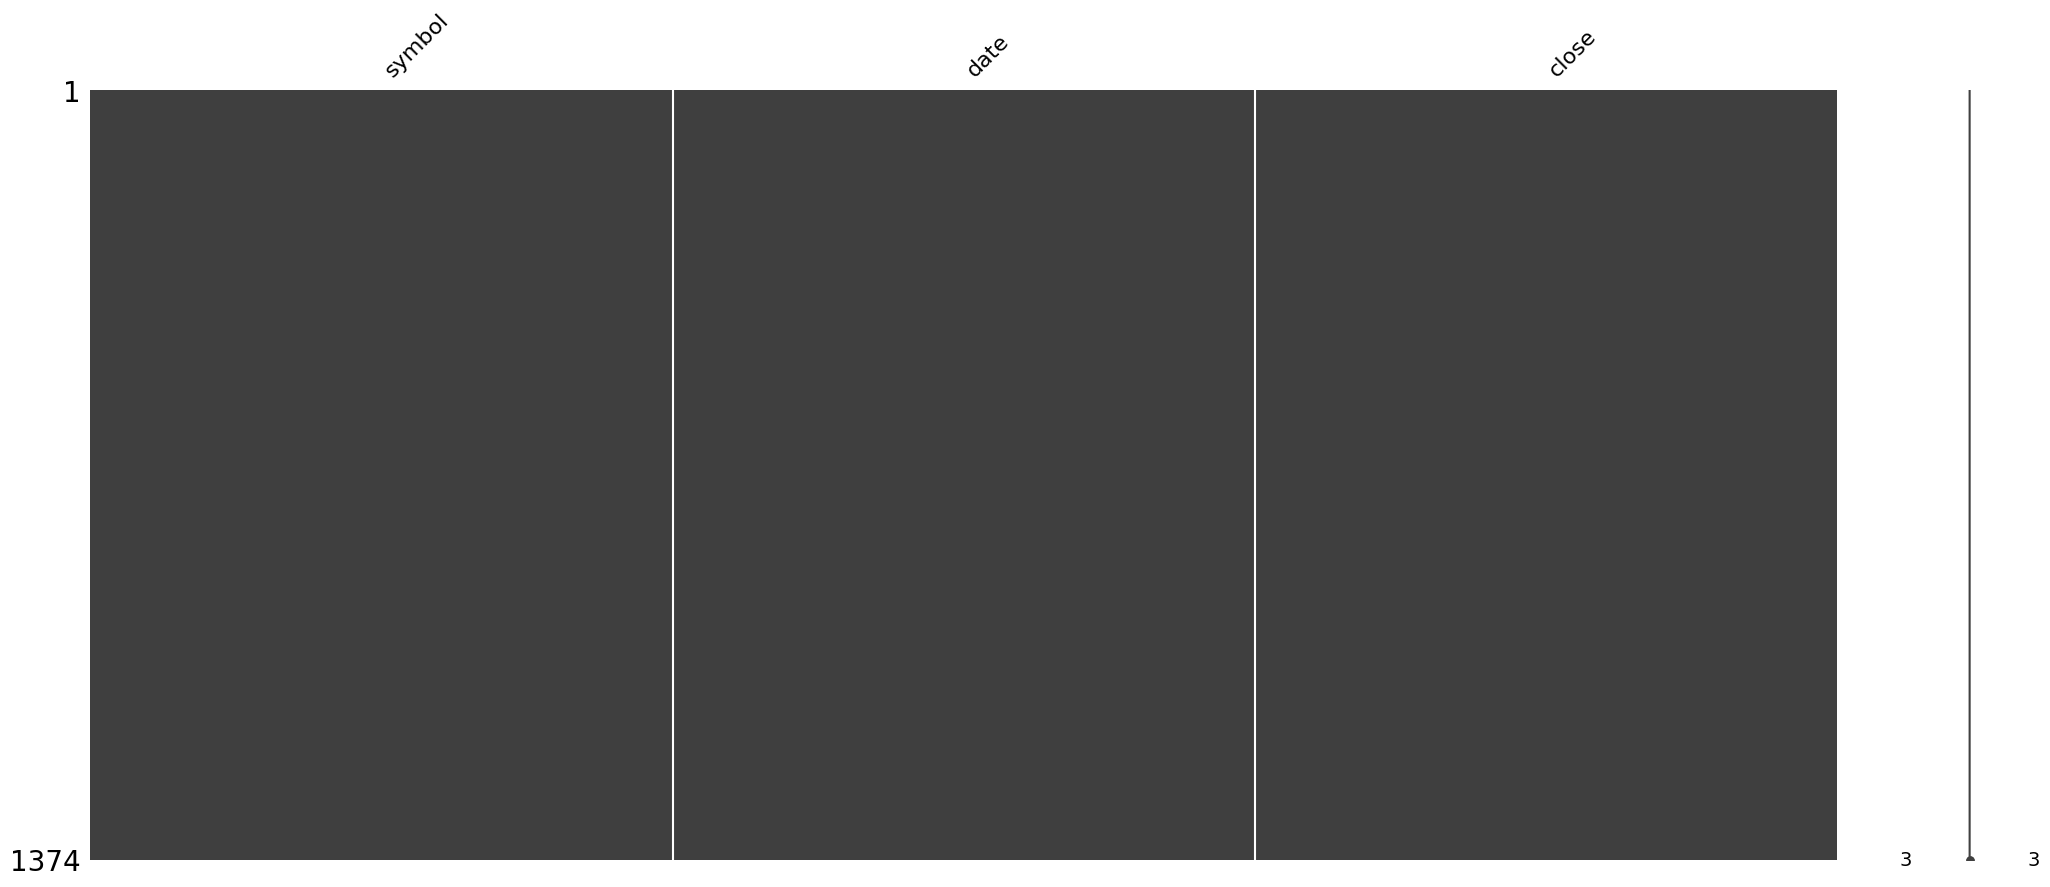

In [106]:

df_final= df_final.dropna(axis=0, how="any")

print(mso.matrix(df_final))

Pivotamos la tabla para graficar más cómodamente y normalizados 

Datos transformados a formato 'ancho' (wide):
symbol        AAPL    GOOG
date                      
2023-02-02  148.72  108.06
2023-02-03  152.35  104.50
2023-02-06  149.62  102.77
2023-02-07  152.50  107.31
2023-02-08  149.81   99.32
Generando gráfico de rendimiento normalizado...


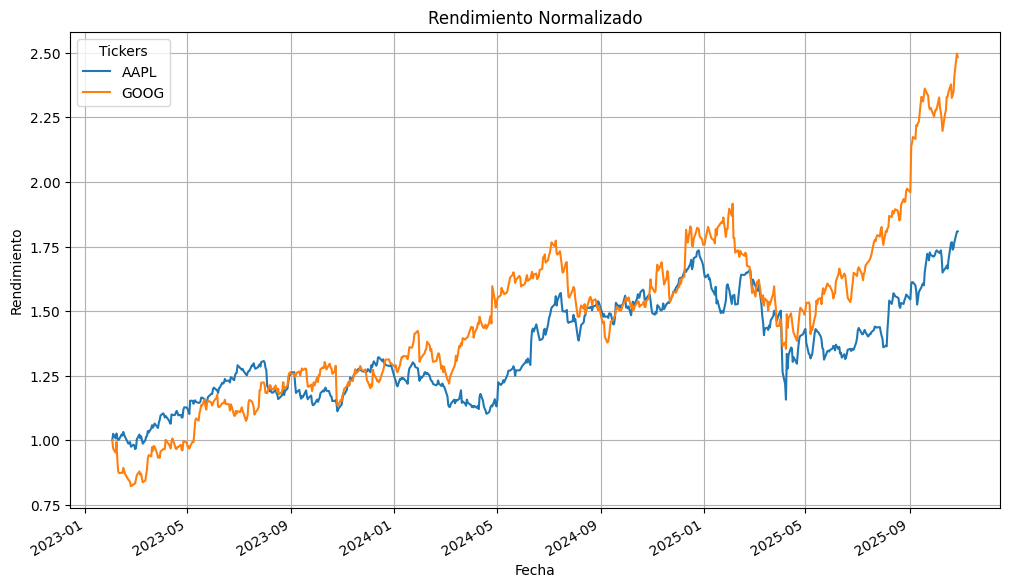

In [107]:
# -- PIVOTAR DATOS PARA GRÁFICOS ---
#

df_wide = df_final.pivot(index='date', columns='symbol', values='close')

print("Datos transformados a formato 'ancho' (wide):")
print(df_wide.head())

# ---  GRÁFICAR DATOS NORMALIZADOS ---

# Importamos la librería de gráficos


# 1. Normalizamos: Dividimos el DataFrame "ancho" por su primera fila (iloc[0])

df_normalizado = (df_wide / df_wide.iloc[0]) 

# 2. Graficamos el DataFrame normalizado
print("Generando gráfico de rendimiento normalizado...")

df_normalizado.plot(figsize=(12, 7))
plt.title('Rendimiento Normalizado')
plt.ylabel('Rendimiento')
plt.xlabel('Fecha')
plt.grid(True)
plt.legend(title='Tickers')
plt.show()

Calculamos la media y mediana de los rendimientos logarítmicos

In [108]:



portfolio_return = log_returns.mean(axis=1)



# -CÁLCULO DE ESTADÍSTICAS ---

# media
mean_returns = log_returns.mean()

# mediana
median_returns = log_returns.median()

print("--- Retornos diarios de la Cartera ---")
print(portfolio_return.head())

print("\n--- Estadísticas de la Cartera ---")
print(f"Media diaria (mu):   {portfolio_return.mean():.6f}")
print(f"Std diaria (sigma): {portfolio_return.std():.6f}")

print("--- Media de Retornos Logarítmicos Diarios ---")
print(mean_returns)

print("\n--- Mediana de Retornos Logarítmicos Diarios ---")
print(median_returns)



--- Retornos diarios de la Cartera ---
date
2023-01-31    0.015296
2023-02-01    0.005891
2023-02-02    0.023180
2023-02-03   -0.002199
2023-02-06   -0.007366
dtype: float64

--- Estadísticas de la Cartera ---
Media diaria (mu):   0.000862
Std diaria (sigma): 0.010427
--- Media de Retornos Logarítmicos Diarios ---
symbol
AAPL    0.000805
GOOG    0.001350
JPM     0.001065
MSFT    0.001100
XOM    -0.000011
dtype: float64

--- Mediana de Retornos Logarítmicos Diarios ---
symbol
AAPL    0.001275
GOOG    0.002469
JPM     0.001690
MSFT    0.001226
XOM     0.000183
dtype: float64


Calculamos retornos logaritmicos y matriz de correlación

DataFrame de Retornos Logarítmicos Diarios:
symbol          AAPL      GOOG
date                          
2023-02-03  0.024115 -0.033500
2023-02-06 -0.018082 -0.016694
2023-02-07  0.019066  0.043228
2023-02-08 -0.017797 -0.077375
2023-02-09 -0.006966 -0.046472


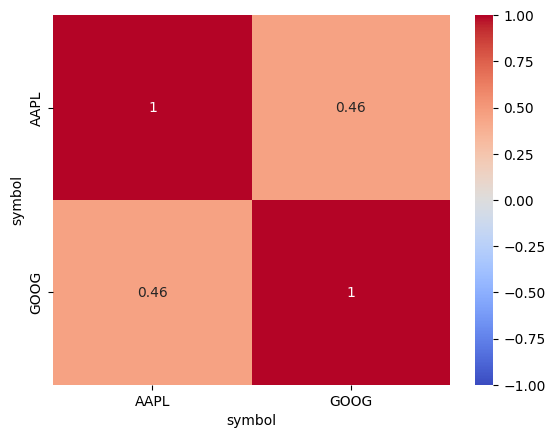

In [109]:

log_returns = np.log(df_wide).diff().dropna()

print("DataFrame de Retornos Logarítmicos Diarios:")
print(log_returns.head())

sns.heatmap(log_returns.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()



Estudio de la media y la mediana comparada con una distribución normal.

Generando análisis de distribución para cada activo...



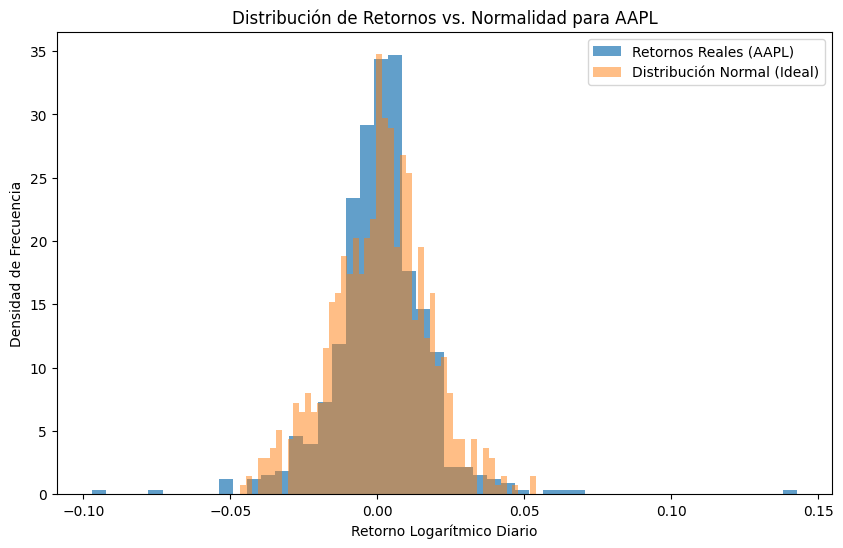

--- Estadísticos para AAPL ---
Media            = 0.000864
Desv. Estándar   = 0.016414
Skewness (Asimetría) = 0.5115
Kurtosis (Curtosis)  = 11.1793
--------------------------------



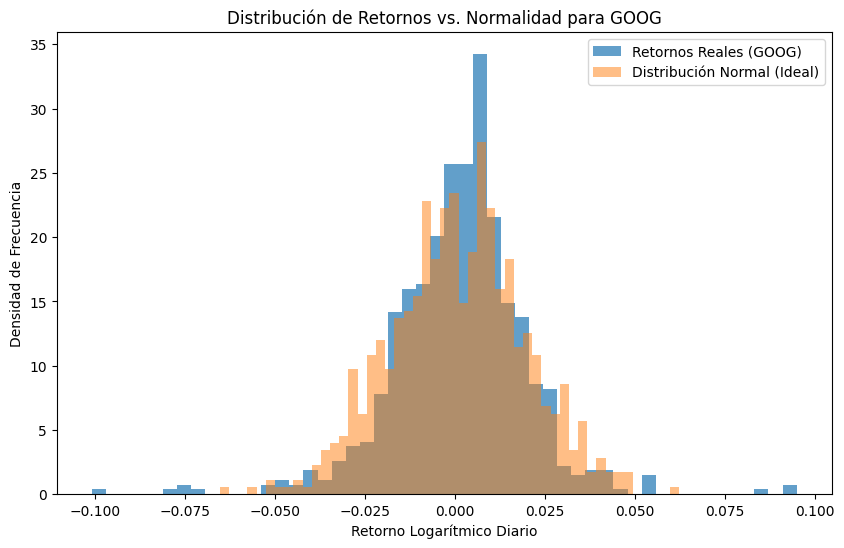

--- Estadísticos para GOOG ---
Media            = 0.001326
Desv. Estándar   = 0.018673
Skewness (Asimetría) = -0.2129
Kurtosis (Curtosis)  = 4.6670
--------------------------------



In [110]:
# ---  ANÁLISIS DE DISTRIBUCIÓN DE RETORNOS ---
#
# Comparamos la distribución real de cada activo contra una
# distribución normal "ideal" (generada por computadora)
# que tiene exactamente la misma media y desviación estándar.

# Necesitamos la función para generar números aleatorios
from numpy.random import default_rng
rng = default_rng()

# El DataFrame 'log_returns' ya lo calculamos en la Celda 12
print("Generando análisis de distribución para cada activo...\n")

# Iteramos sobre cada columna (activo) en nuestro DataFrame de retornos
for activo in log_returns.columns:
    
    # 1. Seleccionamos los retornos del activo y quitamos los NaN (por si acaso)
    rets = log_returns[activo].dropna()
    
    # 2. Creamos la distribución "ideal"
    #    Generamos números aleatorios con la misma media (loc) y desv. (scale)
    data_normal = rng.normal(
        size=len(rets),      # Misma cantidad de datos
        loc=rets.mean(),     # Misma media
        scale=rets.std()     # Misma desviación estándar
    )
    
    # 3. Creamos un DataFrame temporal para el gráfico
    df_compare = pd.DataFrame({
        f"Real_{activo}": rets.values, 
        "Normal_Ideal": data_normal
    })
    
    # 4. Graficamos el histograma
    plt.figure(figsize=(10, 6))
    
    # 'density=True' normaliza el histograma para que el área bajo la curva sea 1
    # Esto permite una comparación justa de las formas
    plt.hist(df_compare[f"Real_{activo}"], bins=50, alpha=0.7, label=f"Retornos Reales ({activo})", density=True)
    plt.hist(df_compare["Normal_Ideal"], bins=50, alpha=0.5, label="Distribución Normal (Ideal)", density=True)
    
    plt.title(f"Distribución de Retornos vs. Normalidad para {activo}")
    plt.xlabel("Retorno Logarítmico Diario")
    plt.ylabel("Densidad de Frecuencia")
    plt.legend()
    plt.show()
    
    # 5. Imprimimos los estadísticos clave
    print(f"--- Estadísticos para {activo} ---")
    print(f"Media            = {rets.mean():.6f}")
    print(f"Desv. Estándar   = {rets.std():.6f}")
    print(f"Skewness (Asimetría) = {rets.skew():.4f}")
    print(f"Kurtosis (Curtosis)  = {rets.kurtosis():.4f}")
    print("-"*(28 + len(activo)) + "\n")

Ahora vamos con las simulaciones Monte-Carlo


--- Iniciando Simulación Monte Carlo ---
Parámetros usados para la simulación del portfolio:
  - Valor inicial (S0): 100
  - Días a simular (n_days): 30
  - Número de simulaciones (n_sims): 3000
  - Media diaria retorno log (mu_daily): 0.001095
  - Desv. Est. diaria retorno log (sigma_daily): 0.015002
  - Paso de tiempo (dt): 0.003968

Generando gráfico de las simulaciones...
Gráfico 'monte_carlo_simulation.png' guardado.


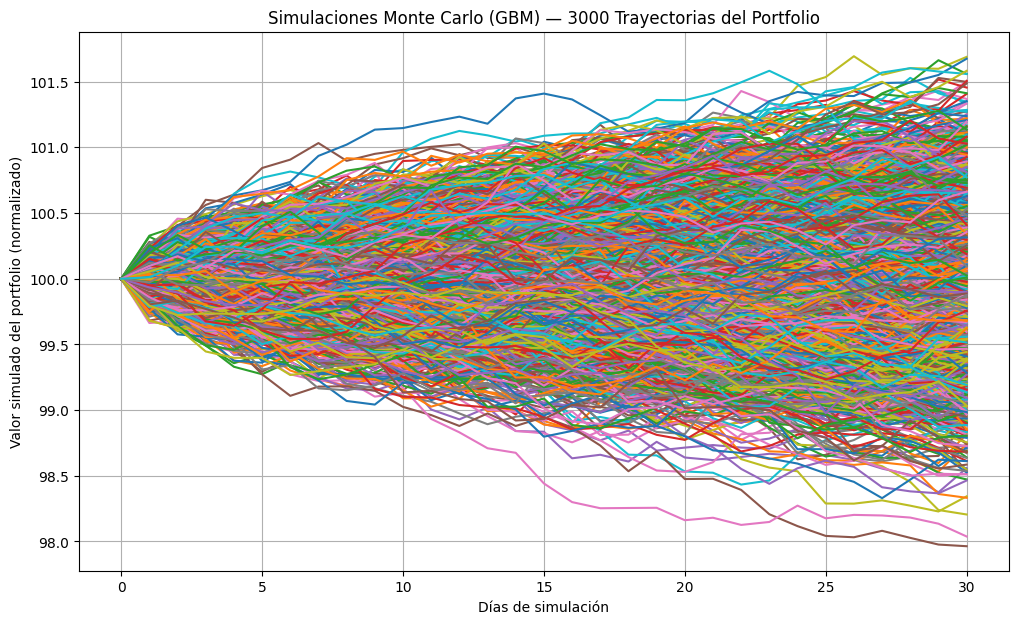

In [111]:

# --- SIMULACIÓN MONTE CARLO ---
print("\n--- Iniciando Simulación Monte Carlo ---")

# Parámetros de la simulación
n_sims = 3000      # Número de simulaciones
n_days = 30       # Días a simular hacia adelante
S0 = 100          # Valor inicial del portfolio (normalizado a 100 para comparar)
dt = 1 / 252      # Paso de tiempo (asumiendo 252 días de trading al año)

try:
    # 1. Asegurarse de tener los retornos logarítmicos de TODOS los activos
    #    (df_wide viene de la celda 17)
    log_returns_mc = np.log(df_wide).diff().dropna()

    # 2. Calcular los retornos diarios de un portfolio EQUITATIVO
    #    (misma inversión en cada activo)
    portfolio_return_mc = log_returns_mc.mean(axis=1)

    # 3. Calcular la media y desviación estándar de los retornos logarítmicos del portfolio
    mu_daily = portfolio_return_mc.mean()
    sigma_daily = portfolio_return_mc.std()

    print(f"Parámetros usados para la simulación del portfolio:")
    print(f"  - Valor inicial (S0): {S0}")
    print(f"  - Días a simular (n_days): {n_days}")
    print(f"  - Número de simulaciones (n_sims): {n_sims}")
    print(f"  - Media diaria retorno log (mu_daily): {mu_daily:.6f}")
    print(f"  - Desv. Est. diaria retorno log (sigma_daily): {sigma_daily:.6f}")
    print(f"  - Paso de tiempo (dt): {dt:.6f}")

    # Inicializar generador de números aleatorios
    rng = default_rng()

    # 4. Generar las trayectorias (Usando Movimiento Browniano Geométrico - GBM)
    paths = np.zeros((n_days + 1, n_sims))
    paths[0, :] = S0 # Establecer el valor inicial para todas las simulaciones

    for t in range(1, n_days + 1):
        # Generar números aleatorios normales estándar para este paso de tiempo
        Z = rng.standard_normal(n_sims)
        # Calcular el precio para este día en todas las simulaciones
        paths[t, :] = paths[t - 1, :] * np.exp(
            (mu_daily - 0.5 * sigma_daily**2) * dt +  # Componente de deriva
            sigma_daily * np.sqrt(dt) * Z             # Componente aleatorio (shock)
        )

    # 5. Graficar las trayectorias simuladas usando Matplotlib
    print("\nGenerando gráfico de las simulaciones...")
    plt.figure(figsize=(12, 7)) # Crear una figura nueva para el gráfico
    plt.plot(paths)
    plt.title(f'Simulaciones Monte Carlo (GBM) — {n_sims} Trayectorias del Portfolio')
    plt.xlabel('Días de simulación')
    plt.ylabel('Valor simulado del portfolio (normalizado)')
    plt.grid(True)
    # No añadimos leyenda para no saturar el gráfico con 100 entradas
    plt.savefig('monte_carlo_simulation.png') # Guardar el gráfico como imagen
    print("Gráfico 'monte_carlo_simulation.png' guardado.")

except NameError as e:
     print(f"Error: La variable 'df_wide' no está definida. Asegúrate de ejecutar la celda 17 antes. ({e})")
except Exception as e:
    print(f"Ocurrió un error inesperado durante la simulación: {e}")

Con estas simulaciones calculamos el Value at risk.(Utiliza los datos de las simulaciones monte Carlo de la celda anterior)


--- Calculando Value at Risk (VaR) ---
Resultados basados en 3000 simulaciones de 30 días:
Nivel de Confianza: 95%
Nivel de Significancia (alpha): 5%
Percentil 5 de retorno simulado a 30 días: -0.0057
Value at Risk (VaR) al 95% de confianza para 30 días: 0.0057 (o 0.57%)
Interpretación: Basado en 3000 simulaciones, hay una probabilidad del 5% de que la pérdida del portfolio exceda el 0.57% en los próximos 30 días.

Generando histograma de retornos simulados a 30 días y VaR...
Gráfico 'monte_carlo_paths_var_histogram.png' guardado.


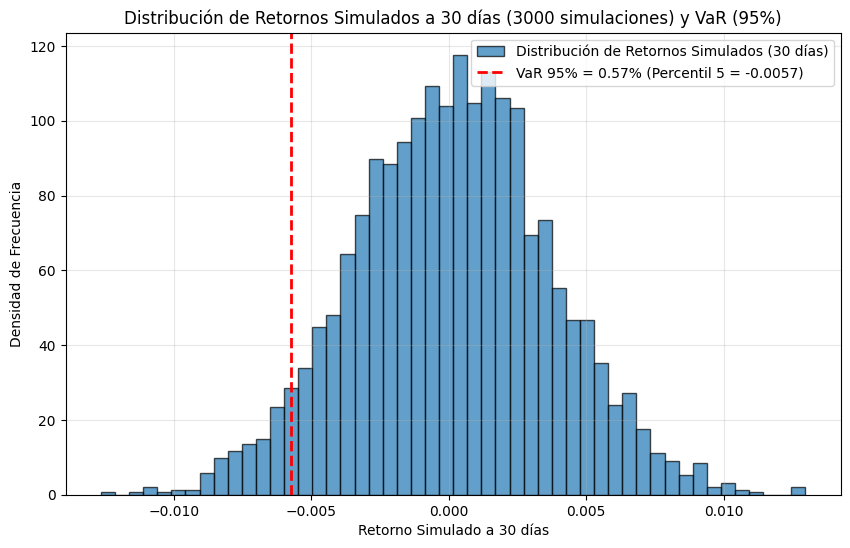

In [70]:

# --- Value at Risk (VaR) Calculation using previous Simulation Paths ---
print("\n--- Calculando Value at Risk (VaR) ---")

try:
    # 1. Verificar si las variables necesarias de la simulación anterior existen
    if 'paths' not in locals() or 'S0' not in locals() or 'n_days' not in locals() or 'n_sims' not in locals():
        raise NameError("Variables de simulación (paths, S0, n_days, n_sims) no encontradas. Ejecuta la celda Monte Carlo de trayectorias primero.")

    # 2. Obtener los valores simulados finales (del último día simulado)
    final_values = paths[n_days, :] # Última fila (día n_days) para todas las simulaciones (n_sims)

    # 3. Calcular los retornos simulados (retornos simples) sobre el período simulado (n_days)
    #    (Valor Final - Valor Inicial) / Valor Inicial
    simulated_returns = (final_values - S0) / S0

    # 4. Definir nivel de confianza y calcular VaR
    confidence_level = 0.95
    alpha = 1 - confidence_level # Nivel de significancia (0.05)

    # VaR es el percentil alpha de las *pérdidas* (retornos negativos),
    # o el negativo del percentil alpha de los *retornos*.
    var_percentile = np.percentile(simulated_returns, alpha * 100) # 5º percentil para confianza del 95%

    # El VaR se expresa como una pérdida potencial positiva
    var_value = -var_percentile

    print(f"Resultados basados en {n_sims} simulaciones de {n_days} días:")
    print(f"Nivel de Confianza: {confidence_level:.0%}")
    print(f"Nivel de Significancia (alpha): {alpha:.0%}")
    print(f"Percentil {alpha*100:.0f} de retorno simulado a {n_days} días: {var_percentile:.4f}")
    print(f"Value at Risk (VaR) al {confidence_level:.0%} de confianza para {n_days} días: {var_value:.4f} (o {var_value:.2%})")
    print(f"Interpretación: Basado en {n_sims} simulaciones, hay una probabilidad del {alpha:.0%} de que la pérdida del portfolio exceda el {var_value:.2%} en los próximos {n_days} días.")

    # 5. Graficar histograma de retornos y marcar el VaR
    print(f"\nGenerando histograma de retornos simulados a {n_days} días y VaR...")
    plt.figure(figsize=(10, 6)) # Crear figura nueva
    plt.hist(simulated_returns, bins=50, alpha=0.7, density=True, edgecolor='black', label=f'Distribución de Retornos Simulados ({n_days} días)')
    # Añadir línea vertical para el VaR (en el valor de pérdida, que es -VaR95)
    plt.axvline(var_percentile, color='r', linestyle='dashed', linewidth=2,
                label=f'VaR {confidence_level:.0%} = {var_value:.2%} (Percentil {alpha*100:.0f} = {var_percentile:.4f})')
    plt.title(f'Distribución de Retornos Simulados a {n_days} días ({n_sims} simulaciones) y VaR ({confidence_level:.0%})')
    plt.xlabel(f'Retorno Simulado a {n_days} días')
    plt.ylabel('Densidad de Frecuencia')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('monte_carlo_paths_var_histogram.png') # Guardar gráfico
    print("Gráfico 'monte_carlo_paths_var_histogram.png' guardado.")


except NameError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado durante el cálculo del VaR: {e}")